Here, for prediction we will follow following patter.  
Step 1. Check the data and try to find a proper pattern, check seasonility or trend present.  
Step 2. Here we will try two methods to deal with the data, first we try to remove seasonility from the time-series and try to visually find (p,d,q) using Autocorrelation and Partial Autocorrelation plots and test how it performs on ARIMA.  
Then using the same hyperparameters, we will check the performance on SARIMAX.
Then we wil try to find the best hyperparameters by using grid search.

In [1]:
import pandas as pd #Used to plot Dataframe, data processing
import numpy as np #Used fot Linear Algebra
import matplotlib.pyplot as plt # to plot graphs
%matplotlib inline
import seaborn as sns
import random as rd #generate random numbers
import datetime

In [2]:
#Import timeseries  fn
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller,pacf,acf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from sklearn.metrics import mean_squared_error

In [3]:
sales=pd.read_csv("sales_train.csv")
item_cat=pd.read_csv("item_categories.csv")
items=pd.read_csv("items.csv")
shops=pd.read_csv("shops.csv")
test=pd.read_csv("test.csv")
sub=pd.read_csv("sample_submission.csv")

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
item_cat.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [7]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [8]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [9]:
len(item_cat["item_category_name"].unique())

84

In [10]:
len(items["item_name"].unique())

22170

In [11]:
sales['date']=pd.to_datetime(sales['date'],format="%d.%m.%Y")

In [12]:
sales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0
2935845,2015-10-09,33,25,7460,299.00,1.0
2935846,2015-10-14,33,25,7459,349.00,1.0
2935847,2015-10-22,33,25,7440,299.00,1.0


In [13]:
monthly_sales=sales.groupby(["date_block_num","shop_id","item_id"])[
    "date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})


In [14]:
monthly_sales.head(10000)

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
...                                   ...        ...        ...          ...
               8       12927   2013-01-13 2013-01-13      149.0          1.0
                       12929   2013-01-27 2013-01-27      199.0          1.0
                       12956   2013-01-14 2013-01-14      199.0          1.0
                       12962   2013-01-09 2013-01-09      199.0          1.0
                       12964   2013-01-04 2013-01-04      199.0          1.0

[10000 rows x 4 columns]

In [15]:
x=items.groupby(['item_category_id']).count()
x=x.sort_values(by='item_id',ascending=False)
x=x.iloc[0:10].reset_index()
x

,item_category_id,item_name,item_id
0,40,5035,5035
1,55,2365,2365
2,37,1780,1780
3,31,1125,1125
4,58,790,790
5,30,756,756
6,72,666,666
7,19,628,628
8,61,598,598
9,23,501,501


Text(0, 0.5, 'Count')

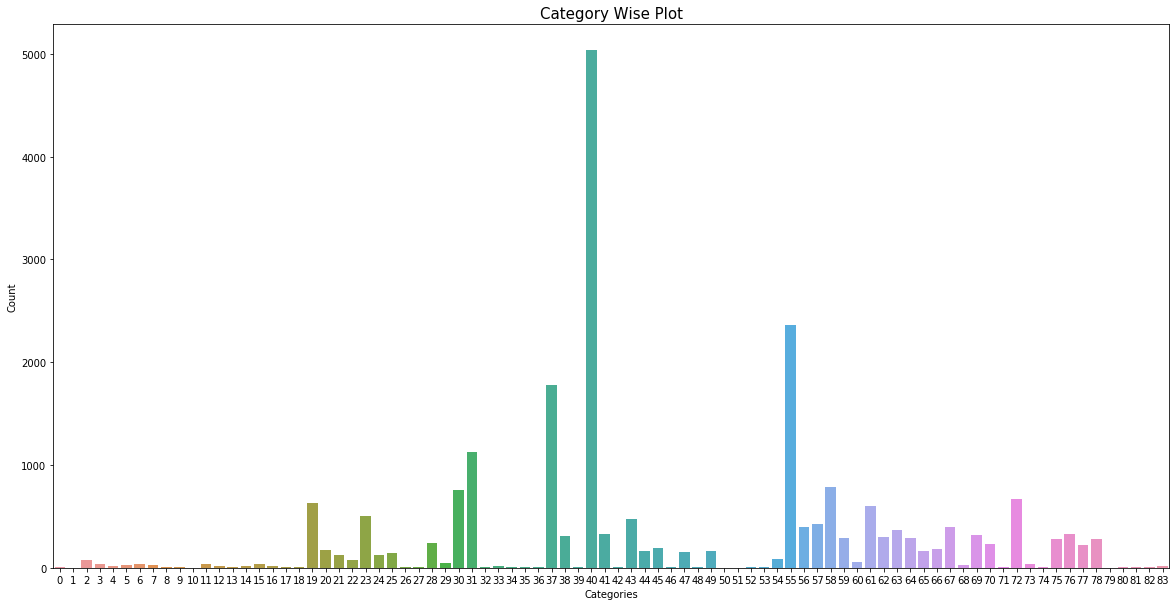

In [16]:
plt.figure(figsize=(20,10))
sns.countplot(items["item_category_id"])
plt.title("Category Wise Plot",fontsize=15)
plt.xlabel("Categories")
plt.ylabel("Count")

In [17]:
ts=sales.groupby(['date_block_num'])["item_cnt_day"].sum()

In [18]:
ts

date_block_num
0     131479.0
1     128090.0
2     147142.0
3     107190.0
4     106970.0
5     125381.0
6     116966.0
7     125291.0
8     133332.0
9     127541.0
10    130009.0
11    183342.0
12    116899.0
13    109687.0
14    115297.0
15     96556.0
16     97790.0
17     97429.0
18     91280.0
19    102721.0
20     99208.0
21    107422.0
22    117845.0
23    168755.0
24    110971.0
25     84198.0
26     82014.0
27     77827.0
28     72295.0
29     64114.0
30     63187.0
31     66079.0
32     72843.0
33     71056.0
Name: item_cnt_day, dtype: float64

Text(0, 0.5, 'Sale')

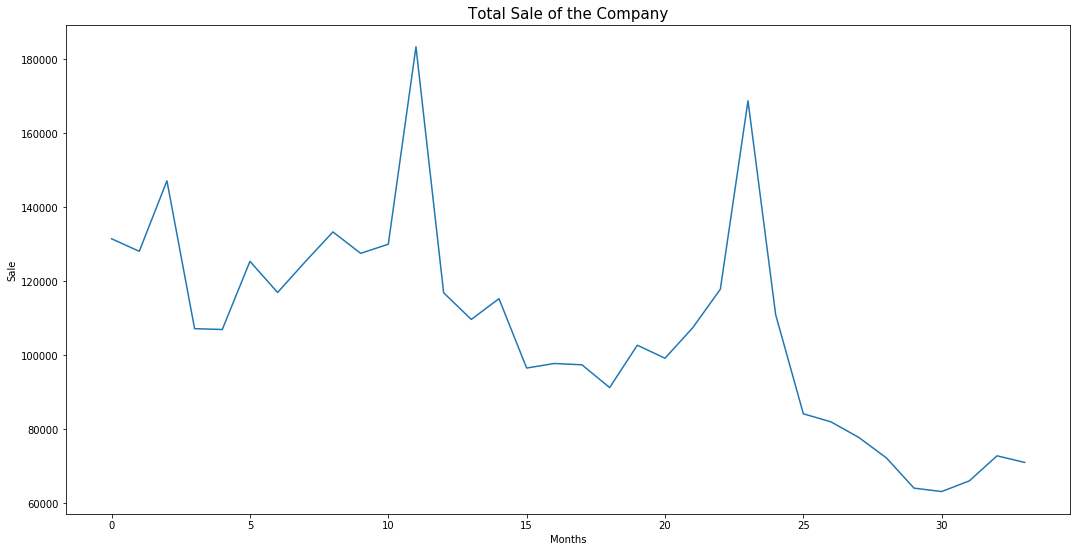

In [19]:
plt.figure(figsize=(18,9))
plt.plot(ts)
plt.title("Total Sale of the Company",size=15)
plt.xlabel("Months")
plt.ylabel("Sale")

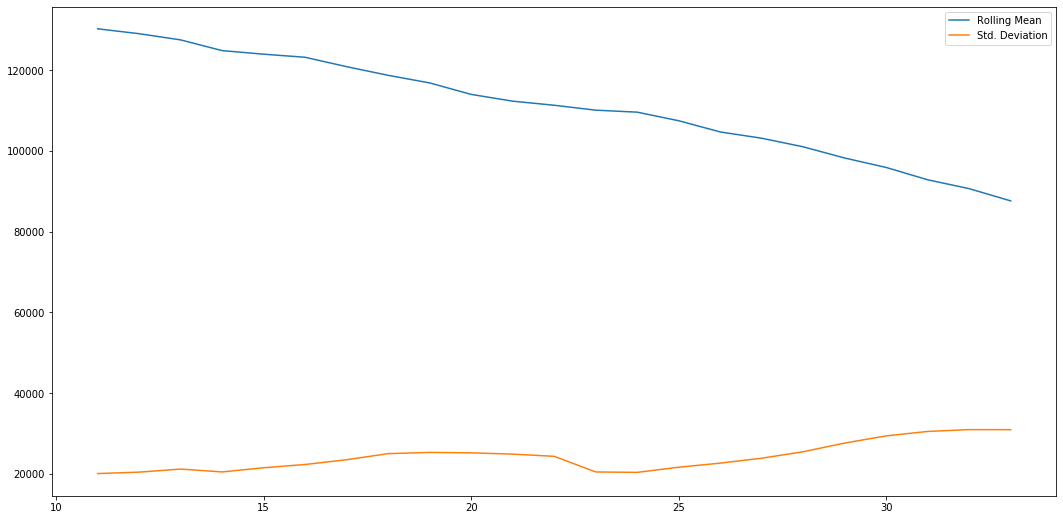

In [20]:
# Check the trend in a window of 12(yearly basis)
plt.figure(figsize=(18,9))
plt.plot(ts.rolling(window=12).mean(),label="Rolling Mean")
plt.plot(ts.rolling(12).std(),label="Std. Deviation")
plt.legend()

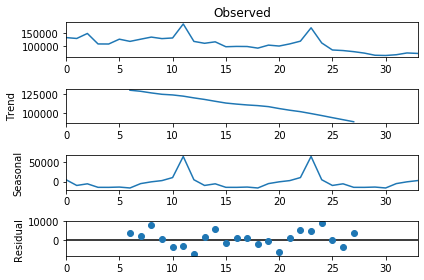

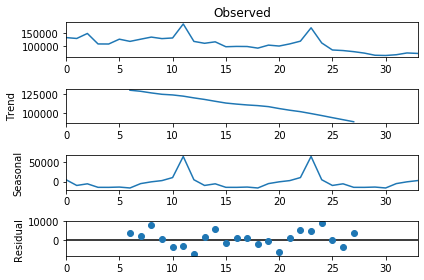

In [21]:
import statsmodels.api as sm
res= sm.tsa.seasonal_decompose(ts.values,model='additive',period=12)
res.plot()

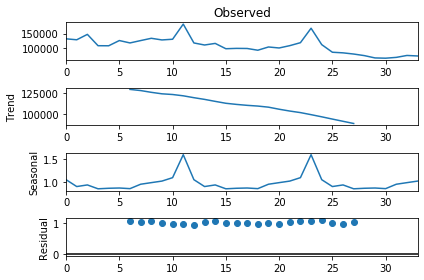

<Figure size 1152x864 with 0 Axes>

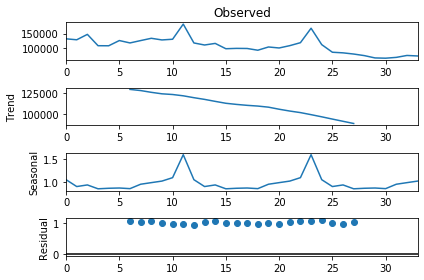

In [22]:
res= sm.tsa.seasonal_decompose(ts.values,model='multiplicative',period=12)
plt.figure(figsize=(16,12))
res.plot()

In [23]:
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


Why is  Stationarizing the data important? When running a linear regression the assumption is that all of the observations are all independent of each other. In a time series, however, we know that observations are time dependent. It turns out that a lot of nice results that hold for independent random variables (law of large numbers and central limit theorem to name a couple) hold for stationary random variables. So by making the data stationary, we can actually apply regression techniques to this time dependent variable.

There are two ways you can check the stationarity of a time series. The first is by looking at the data. By visualizing the data it should be easy to identify a changing mean or variation in the data. For a more accurate assessment there is the Dickey-Fuller test. I won’t go into the specifics of this test, but if the ‘Test Statistic’ is greater than the ‘Critical Value’ than the time series is stationary. Below there is more details on how to use the test.

Now we need to check if the plot is stationary or not by AD Fuller test. 
Null Hypothesis of the test is that the time series has a unit root ,i.e it is non-stationary(has some time dependent feature)
Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
We can check this hypothesis with the help of p-value. A p-value less than some threshold means we can accept the null hypothesis.
If p<=0.05, accept null hypothesis.
If p>0.05, reject null hypothesis.
Here our Test Statistics value is greater than Critical values, byt it should lie in between 1% and 5% critical values

In [24]:
#Remove trend
from pandas import Series as Series
def difference(dataset,interval=1):
    diff=[]
    for i in range(interval,len(dataset)):
        value=(dataset[i]-dataset[i-interval])
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

Text(0, 0.5, 'Sales')

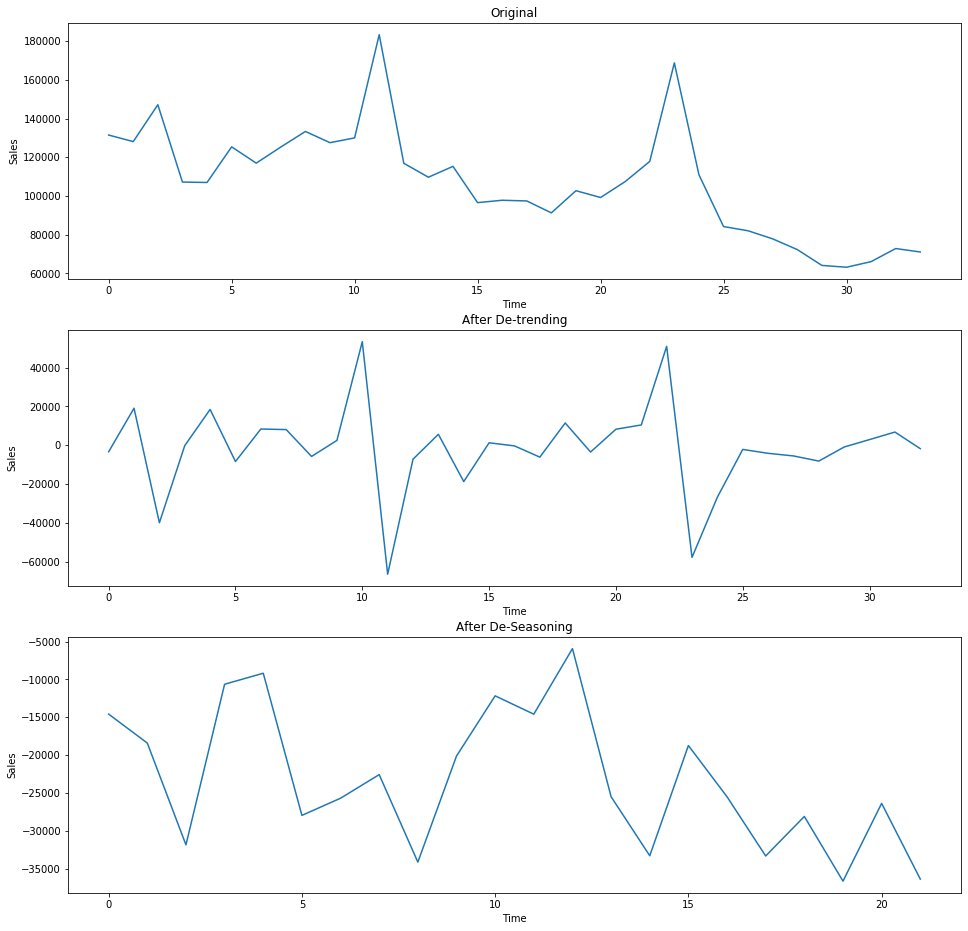

In [25]:
ts=sales.groupby(['date_block_num'])["item_cnt_day"].sum()
fig,a =plt.subplots(3,figsize=(16,16))
a[0].plot(ts)
a[0].set_title("Original")
a[0].set_xlabel("Time")
a[0].set_ylabel("Sales")

new_ts=difference(ts,1)
a[1].plot(new_ts)
a[1].set_title("After De-trending")
a[1].set_xlabel("Time")
a[1].set_ylabel("Sales")

new_ts=difference(ts,12) #Here we assume seasonility is at an interval of 12
a[2].plot(new_ts)
a[2].set_title("After De-Seasoning")
a[2].set_xlabel("Time")
a[2].set_ylabel("Sales")


In [26]:
test_stationarity(new_ts)

Results of Dickey-Fuller Test:
Test Statistic                 -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


We can lower the p-value further by de-trending the de-seasoning plot but the p-value we obtained after deseasoning is less than critical value, so it will still give accurate results.

Text(0.5, 1.0, 'Partial AutoCorrelation Plot')

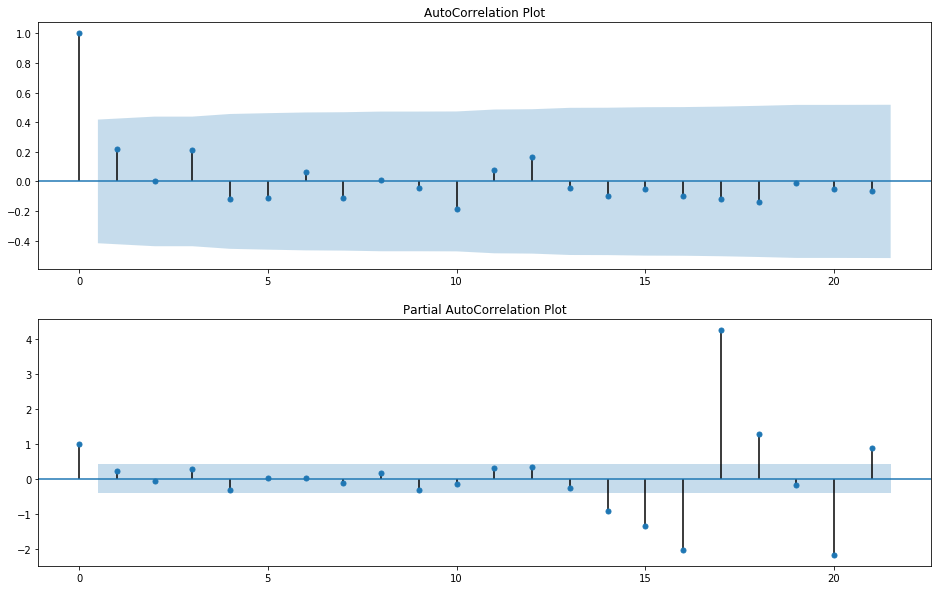

In [27]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig, ax= plt.subplots(2,figsize=(16,10))
sm.graphics.tsa.plot_acf(new_ts,lags=21,ax=ax[0])
ax[0].set_title("AutoCorrelation Plot")
sm.graphics.tsa.plot_pacf(new_ts,lags=21,ax=ax[1])
ax[1].set_title("Partial AutoCorrelation Plot")


After analysing the above plots we get different values of (p,d,q) in both time-series(with and without seasonility).  
For timeseries without seasonility(p,d,q)=(1,1,1)  

In [28]:
model=ARIMA(ts,order=(1,1,1))
model_fit=model.fit()

In [29]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.item_cnt_day   No. Observations:                   33
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -373.574
Method:                       css-mle   S.D. of innovations          19171.751
Date:                Wed, 10 Jun 2020   AIC                            755.147
Time:                        13:25:23   BIC                            761.133
Sample:                             1   HQIC                           757.161
                                                                              
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -1929.1764    547.482     -3.524      0.000   -3002.221    -856.132
ar.L1.D.item_cnt_day     0.4257      0.163      2.616      0.009       0.107       0.745
ma.L1.D.item_cnt_day    -1.0000      0.090    -11.111      0.000      -1.176      -0.824
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.3491           +0.0000j            2.3491            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [30]:
new_ts1=pd.DataFrame(ts)

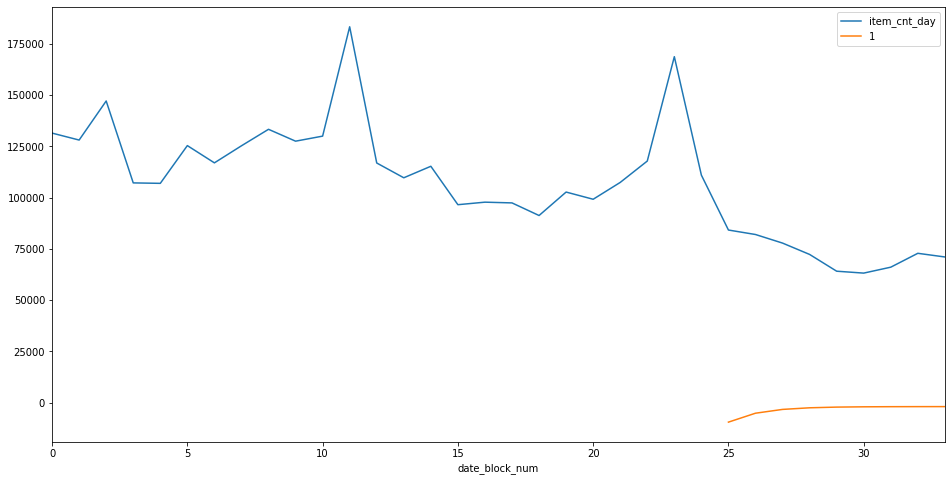

In [31]:

new_ts1[1]=model_fit.predict(start=25,end=33,dynamic=True)
new_ts1[['item_cnt_day',1]].plot(figsize=(16,8))

SARIMAX MODEL FROM HERE.  
ARIMA model did not perform well here because the model had seasonility thus we need SARIMAX model.

In [32]:
model=sm.tsa.statespace.SARIMAX(ts,order=(3, 2, 2),seasonal_order=(2,1,2,12))
results=model.fit()

In [34]:
new_ts11=pd.DataFrame(ts)

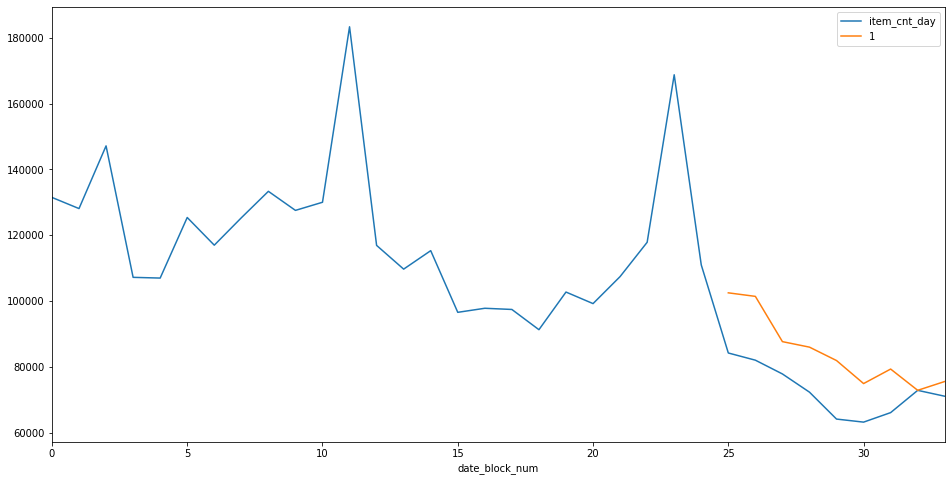

In [35]:

new_ts11[1]=results.predict(start=25,end=33,dynamic=True)
new_ts11[['item_cnt_day',1]].plot(figsize=(16,8))

In [36]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       item_cnt_day   No. Observations:                   34
Model:             SARIMAX(3, 2, 2)x(2, 1, 2, 12)   Log Likelihood                -211.962
Date:                            Wed, 10 Jun 2020   AIC                            443.923
Time:                                    13:26:30   BIC                            453.880
Sample:                                         0   HQIC                           445.867
                                             - 34                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1485      1.451      0.102      0.918      -2.695       2.992
ar.L2         -0.0206      0.265     -0.078      0.938      -0.541       0.500
ar.L3         -0.1005      0.152     -0.663      0.507      -0.397       0.197
ma.L1         -0.9937      2.308     -0.431      0.667      -5.517       3.530
ma.L2         -0.0006      1.443     -0.000      1.000      -2.829       2.828
ar.S.L12      -0.4513     10.410     -0.043      0.965     -20.854      19.952
ar.S.L24      -0.0164      7.219     -0.002      0.998     -14.165      14.133
ma.S.L12       0.1613     12.531      0.013      0.990     -24.399      24.722
ma.S.L24      -0.4413     11.861     -0.037      0.970     -23.689      22.806
sigma2       8.97e+07   1.91e-06    4.7e+13      0.000    8.97e+07    8.97e+07
===================================================================================
Ljung-Box (Q):                       16.94   Jarque-Bera (JB):                 0.80
Prob(Q):                              0.59   Prob(JB):                         0.67
Heteroskedasticity (H):               1.31   Skew:                            -0.34
Prob(H) (two-sided):                  0.73   Kurtosis:                         2.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.93e+30. Standard errors may be unstable.
"""

Instead of visualizing the Autocorreltion and Partial Autocorrelation plots we can just frid search the best value of the hyperparameters. 

In [37]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [38]:
best_aic = np.inf 
best_order = None
best_mdl = None
best_order_seasonal = None


for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            if(results.aic<best_aic):
                best_order=param
                best_order_seasonal=param_seasonal
                best_aic=results.aic
            
        except:
            continue
            
print('ARIMA best{}x{}12 - AIC:{}'.format(best_order,best_order_seasonal, best_aic))

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:861.9269879437136
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:524.9996990650923
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:487.77769050422165
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:187.2393165092
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:474.2519923108149
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:476.1093451500856
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:215.191475716679
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:188.81911191834513
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:815.53810802294
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:507.5699064448196
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:459.24758720394425
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:183.30943016040533
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:556.4835871574865
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:508.3859784899815
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:228.47476621126648
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:185.2912128782781
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:736.5569476767101
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:445.6127593096316
ARIMA(0, 1,

In [39]:
model=sm.tsa.statespace.SARIMAX(ts,order=(1,1,1),seasonal_order=(0,1,1,12))
results=model.fit()

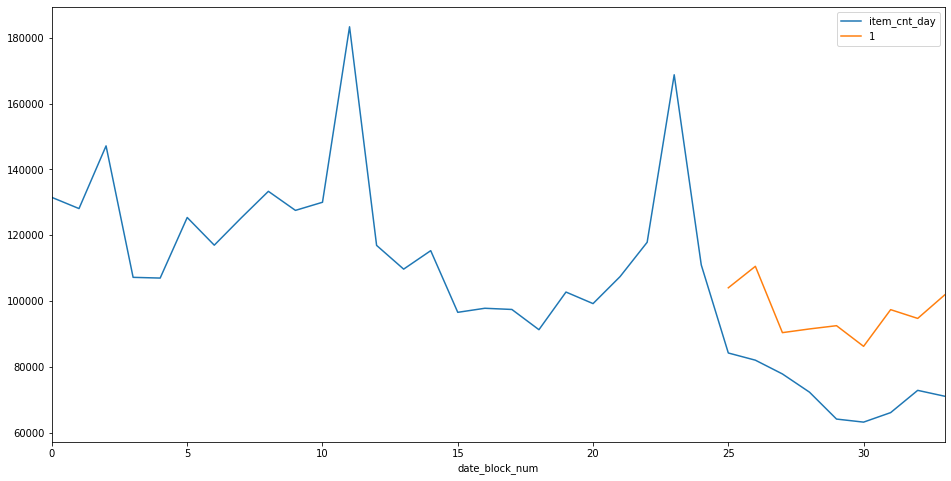

In [40]:

new_ts11[1]=results.predict(start=25,end=33,dynamic=True)
new_ts11[['item_cnt_day',1]].plot(figsize=(16,8))

In [41]:
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2051      4.645      0.044      0.965      -8.899       9.309
ma.L1         -0.1922      4.785     -0.040      0.968      -9.571       9.187
ma.S.L12      -0.0778      0.073     -1.063      0.288      -0.221       0.066
sigma2      9.765e+07   8.43e-08   1.16e+15      0.000    9.76e+07    9.76e+07


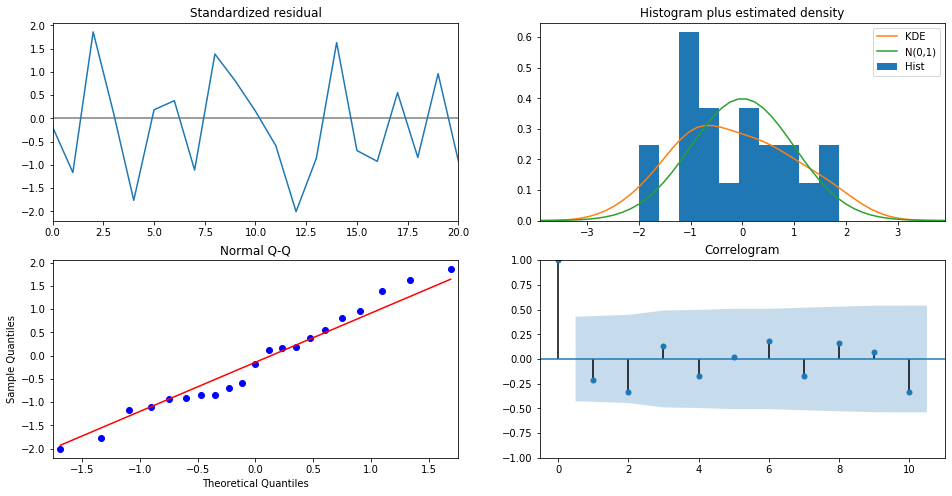

In [42]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()